In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, date

In [24]:
#Reading the data
station_names = pd.read_excel('Station_Names.xlsx')
fare_prices = pd.read_excel('Fare_price_abb.xlsx')
fare_prices.set_index('Unnamed: 0', inplace=True)
last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_201909.xlsx', sheet_name='Total Trips OD', skiprows=[0])
last_ridership.set_index('Unnamed: 0', inplace=True)

In [161]:
last_ridership.head()

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,EM,MT,PL,CC,16,24,GP,BP,DC,CM
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
RM,13.25,137.05,105.70,88.80,483.20,114.15,159.85,151.35,223.80,58.95,...,388.90,396.55,487.20,380.60,199.75,195.45,42.35,81.55,98.20,18.10
EN,170.55,22.55,114.25,107.10,1085.60,180.60,298.85,499.65,662.55,155.00,...,1063.15,1169.90,1085.20,856.65,279.20,220.20,65.30,126.25,186.90,32.20
EP,117.80,102.30,14.50,61.90,862.60,90.15,141.35,313.60,358.60,108.60,...,592.00,702.30,482.30,468.00,136.50,70.15,25.00,44.05,75.15,7.85
NB,96.20,103.50,61.45,14.95,240.75,88.25,99.45,269.45,257.40,87.45,...,730.35,829.95,481.15,578.85,188.25,101.90,26.60,34.30,53.65,6.70
BK,523.40,1145.05,880.00,264.60,45.05,455.35,495.00,636.25,689.85,358.80,...,1108.85,1151.75,1018.55,915.40,416.65,306.25,125.85,149.05,157.35,37.05


In [173]:
#Creating table of average fare for each stations per month
def get_value(table, current_multiplier):
    #table a ridership table, for instance september 2019
    l_total = []
    l_col = []
    l_ind = []
    for index in table.index:
        if index != 'Entries':
            l_ind.append(index)
    for column in list(table.columns):
        if column != 'Exits':
            l_col.append(column)
            temp_l = []
            for index in table.index:
                if index != 'Entries':
                    try:
                        temp_l.append(fare_prices.loc[index, column]*table.loc[index, column]*current_multiplier)
                    except KeyError:
                        temp_l.append(0)
            l_total.append(temp_l)
    df = pd.DataFrame(l_total, columns = l_col)#, index = l_ind)
    df.index = l_ind
    df.fillna(0, inplace=True)
    return df, df.values.sum()
#df, value = get_value(last_ridership)
#df.head()

In [70]:
#Getting total value spent that month
print('Total generated in fares that month is $', df.values.sum())

Total generated in fares that month is $ 41562261.800000004


In [98]:
#Comparing revenues from fares below and above a given threshold
#Remains to plot it over time, as well as total value over time.
def hist_low_fares(df, threshold=4):
    lfr = 0
    hfr = 0
    for index in l_ind:
        for column in l_col:
            try:
                if fare_prices.loc[index, column] <= threshold:
                    lfr += df.loc[index, column]
                else:
                    hfr += df.loc[index, column]
            except KeyError:
                pass
    return lfr, hfr
#hist_low_fares(df)

(13686031.020000001, 24367215.45999998)

In [132]:
#Gets the nb of weekdays, saturdays and sundays in a given month
def get_nb_days(month, year):
    nb_sun = len([1 for i in calendar.monthcalendar(year,month) if i[6] != 0])
    nb_sat = len([1 for i in calendar.monthcalendar(year,month) if i[5] != 0])
    nb_week = calendar.monthrange(year, month)[1] - nb_sat - nb_sun
    return nb_week, nb_sat, nb_sun
#get_nb_days(9,2019)

(21, 4, 5)

In [212]:
def get_value_threshold(initial_threshold=4, rate=3):
#We get fares over time, threshold to define the $ amount between short and long fares, rate increase in prices every 2 years.
    l_hfr = []
    l_lfr = []
    l_tfr = []
    l_date = []
    for year in np.arange(2001, 2020,1):
        
        if year >= 2018:
            c_m = 1 #current multiplier, to account for discounts
        elif 2016 <= year < 2018:
            c_m = (1+rate/100)**(-1)
        elif 2014 <= year < 2016:
            c_m = (1+rate/100)**(-2)
        elif 2012 <= year < 2014:
            c_m = (1+rate/100)**(-3)
        elif 2010 <= year < 2012:
            c_m = (1+rate/100)**(-4)
        elif 2008 <= year < 2010:
            c_m = (1+rate/100)**(-5)
        if 2008 <= year <= 2019:
            threshold = initial_threshold*c_m
        
        for month in np.arange(1,13,1):
            if month >= 10:
                m_str = str(month)
            else:
                m_str = '0'+str(month)
            if year == 2019:
                if month <= 9:
                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Total Trips OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    l_tfr.append(value)
                    l_lfr.append(lfr)
                    l_hfr.append(hfr)
                    l_date.append(date(year,month,1))

            elif year == 2018:
                if month == 1:
                    valuet = 0
                    lfrt = 0
                    hfrt = 0
                    nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_week
                    lfrt += lfr*nb_week
                    hfrt += hfr*nb_week

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sat
                    lfrt += lfr*nb_sat
                    hfrt += hfr*nb_sat

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sun
                    lfrt += lfr*nb_sun
                    hfrt += hfr*nb_sun

                    l_tfr.append(valuet)
                    l_lfr.append(lfrt)
                    l_hfr.append(hfrt)
                    l_date.append(date(year,month,1))

                elif month in [3,4]:
                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Total Trips OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership.drop(last_ridership.tail(1).index,inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    l_tfr.append(value)
                    lfr, hfr = hist_low_fares(df, threshold)
                    l_lfr.append(lfr)
                    l_hfr.append(hfr)
                    l_date.append(date(year,month,1))

                elif month == 2 or month >= 5:
                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Total Trips OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    l_tfr.append(value)
                    lfr, hfr = hist_low_fares(df, threshold)
                    l_lfr.append(lfr)
                    l_hfr.append(hfr)
                    l_date.append(date(year,month,1))

            elif year == 2017:
                valuet = 0
                lfrt = 0
                hfrt = 0
                nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Exits', axis=1, inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_week
                lfrt += lfr*nb_week
                hfrt += hfr*nb_week

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Exits', axis=1, inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_sat
                lfrt += lfr*nb_sat
                hfrt += hfr*nb_sat

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Exits', axis=1, inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_sun
                lfrt += lfr*nb_sun
                hfrt += hfr*nb_sun

                l_tfr.append(valuet)
                l_lfr.append(lfrt)
                l_hfr.append(hfrt)
                l_date.append(date(year,month,1))

            elif year == 2016:
                if month == 1:
                    valuet = 0
                    lfrt = 0
                    hfrt = 0
                    nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_week
                    lfrt += lfr*nb_week
                    hfrt += hfr*nb_week

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sat
                    lfrt += lfr*nb_sat
                    hfrt += hfr*nb_sat

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sun
                    lfrt += lfr*nb_sun
                    hfrt += hfr*nb_sun

                    l_tfr.append(valuet)
                    l_lfr.append(lfrt)
                    l_hfr.append(hfrt)
                    l_date.append(date(year,month,1))

                elif month >= 2:
                    valuet = 0
                    lfrt = 0
                    hfrt = 0
                    nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_week
                    lfrt += lfr*nb_week
                    hfrt += hfr*nb_week

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sat
                    lfrt += lfr*nb_sat
                    hfrt += hfr*nb_sat

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Exits', axis=1, inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sun
                    lfrt += lfr*nb_sun
                    hfrt += hfr*nb_sun

                    l_tfr.append(valuet)
                    l_lfr.append(lfrt)
                    l_hfr.append(hfrt)
                    l_date.append(date(year,month,1))


            elif 2009 <= year <= 2015:
                valuet = 0
                lfrt = 0
                hfrt = 0
                nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                last_ridership = last_ridership[last_ridership.columns[:-12]]
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_week
                lfrt += lfr*nb_week
                hfrt += hfr*nb_week

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                last_ridership = last_ridership[last_ridership.columns[:-12]]
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_sat
                lfrt += lfr*nb_sat
                hfrt += hfr*nb_sat

                last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                last_ridership.set_index('Unnamed: 0', inplace=True)
                last_ridership.drop('Entries', axis=0, inplace=True)
                last_ridership = last_ridership[last_ridership.columns[:-12]]
                df, value = get_value(last_ridership, c_m)
                lfr, hfr = hist_low_fares(df, threshold)
                valuet += value*nb_sun
                lfrt += lfr*nb_sun
                hfrt += hfr*nb_sun

                l_tfr.append(valuet)
                l_lfr.append(lfrt)
                l_hfr.append(hfrt)
                l_date.append(date(year,month,1))

            elif year == 2008:
                if month >= 7:
                    valuet = 0
                    lfrt = 0
                    hfrt = 0
                    nb_week, nb_sat, nb_sun = get_nb_days(month,year)

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Weekday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_week
                    lfrt += lfr*nb_week
                    hfrt += hfr*nb_week

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Saturday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sat
                    lfrt += lfr*nb_sat
                    hfrt += hfr*nb_sat

                    last_ridership = pd.read_excel(r'C:\Users\milam\Documents\Bart\Ridership\Ridership_'+str(year)+m_str+'.xlsx', sheet_name='Sunday OD', skiprows=[0])
                    last_ridership.set_index('Unnamed: 0', inplace=True)
                    last_ridership.drop('Entries', axis=0, inplace=True)
                    last_ridership = last_ridership[last_ridership.columns[:-12]]
                    df, value = get_value(last_ridership, c_m)
                    lfr, hfr = hist_low_fares(df, threshold)
                    valuet += value*nb_sun
                    lfrt += lfr*nb_sun
                    hfrt += hfr*nb_sun

                    l_tfr.append(valuet)
                    l_lfr.append(lfrt)
                    l_hfr.append(hfrt)
                    l_date.append(date(year,month,1))

    df_fares = pd.DataFrame({'Dates':l_date, 'Total fares':l_tfr, 'Long rides': l_hfr, 'Short rides': l_lfr})
    df_fares['Proportion Short'] = 100*df_fares['Short rides']/ (df_fares['Short rides'] + df_fares['Long rides'])
    return df_fares

In [213]:
df_fares = get_value_threshold()
df_fares

,Dates,Total fares,Long rides,Short rides,Proportion Short
0,2008-07-01,3.364956e+07,2.597888e+07,7.670682e+06,22.795783
1,2008-08-01,3.204359e+07,2.462347e+07,7.358067e+06,23.007235
2,2008-09-01,3.252411e+07,2.479514e+07,7.728969e+06,23.763814
3,2008-10-01,3.332058e+07,2.538640e+07,7.934180e+06,23.811651
4,2008-11-01,2.957520e+07,2.246024e+07,7.114964e+06,24.057197
...,...,...,...,...,...
130,2019-05-01,4.295995e+07,2.779887e+07,1.516108e+07,35.291186
131,2019-06-01,4.134930e+07,2.683051e+07,1.451879e+07,35.112550
132,2019-07-01,4.236437e+07,2.760855e+07,1.475582e+07,34.830737
133,2019-08-01,4.356427e+07,2.838665e+07,1.517762e+07,34.839605


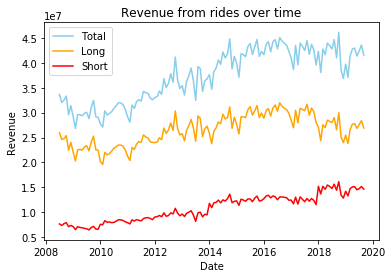

In [217]:
#We want to plot a nice histogram of totals over time.
plt.figure()
plt.plot( 'Dates', 'Total fares', data=df_fares, marker='', markerfacecolor='blue', markersize=12, color='skyblue', label='Total')
plt.plot( 'Dates', 'Long rides', data=df_fares, marker='', color='orange', label='Long')
plt.plot( 'Dates', 'Short rides', data=df_fares, marker='', color='red', label='Short')
plt.legend(loc='upper left')
plt.title('Revenue from rides over time')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

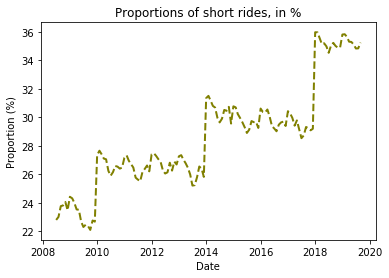

In [215]:
plt.figure()
plt.plot( 'Dates', 'Proportion Short', data=df_fares, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.title('Proportions of short rides, in %')
plt.ylabel('Proportion (%)')
plt.xlabel('Date')
plt.show()